In [1]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/capstone_code")
sys.path.append("/content/drive/My Drive/capstone_code/p_file")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from visualization.plotting import plot_pose, plot_pose_visible

data = pd.read_csv('./processed_penn_data.csv', index_col=[0]).reset_index(drop=True)

In [0]:
class Model_seq2seq:
    def __init__(self,  save_dir, nframe, n_decoder_latent_layer=3, n_encoder_latent_layer = 3, latent_unit = 100, dropout_rate = 0.2, lr = 0.001, early_stop=True):
        from keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
        from keras.models import Model
        from keras.optimizers import Adam, RMSprop, Adadelta 
        # try:
        #     from keras.models import load_model
        #     self.model = load_model(save_dir)
        # except:
        self.save_dir = save_dir
        inputs = Input(shape=(nframe, 13*3))
        x = LSTM(latent_unit, return_sequences=True)(inputs)
        for _ in range(n_encoder_latent_layer-1):
            x = Dropout(dropout_rate)(x)
            x = LSTM(latent_unit, return_sequences=True)(x)
        x = Dropout(dropout_rate)(x)
        x, state_h, state_c = LSTM(latent_unit, return_state=True, return_sequences=True)(x)
        x = LSTM(latent_unit, return_sequences=True)(x, initial_state=[state_h, state_c])
        for _ in range(n_decoder_latent_layer-2):
            x = Dropout(dropout_rate)(x)
            x = LSTM(latent_unit, return_sequences=True)(x)
        x = Dropout(dropout_rate)(x)
        x = LSTM(latent_unit)(x)
        pred = Dense(13*3, activation='relu')(x)

        self.model = Model(inputs=inputs, outputs=pred)
        self.optimizer = Adam()
        self.model.compile(optimizer=self.optimizer,
              loss='mse',
              metrics=['mae'])
        self.early_stop = early_stop

    def training(self, train_input, train_label, val_input, val_label, n_epoch = 50):
        from keras.callbacks import ModelCheckpoint, EarlyStopping
        cp = ModelCheckpoint(self.save_dir, save_best_only=True)
        es = EarlyStopping(monitor="val_mean_absolute_error")
        if self.early_stop:
            self.history = self.model.fit(train_input, train_label, epochs=n_epoch, batch_size=128, validation_data=(val_input, val_label), callbacks=[es, cp])
        else: self.history = self.model.fit(train_input, train_label, epochs=n_epoch, batch_size=128, validation_data=(val_input, val_label), callbacks=[cp])
        return self.history

    def training_generator(self, train_generator, val_generator, n_step, n_step_val, n_epoch = 50):
        from keras.callbacks import ModelCheckpoint, EarlyStopping
        cp = ModelCheckpoint(self.save_dir, save_best_only=True)
        es = EarlyStopping(monitor="val_mean_absolute_error")
        if self.early_stop:
            self.history = self.model.fit_generator(generator=train_generator, epochs=n_epoch, steps_per_epoch=n_step, validation_data=val_generator, validation_steps=n_step_val, callbacks=[es, cp])
        else: self.history = self.model.fit_generator(generator=train_generator, epochs=n_epoch, steps_per_epoch=n_step, validation_data=val_generator, validation_steps=n_step_val, callbacks=[cp])
        return self.history
    
    def predict(self, _input):
        return self.model.predict(_input)

In [8]:
from preprocessing.serialization import serialize_data_next_frame
# from models.prediction import Model_seq2seq, Model
from sklearn.model_selection import train_test_split
from models.data_generator import data_generator_nf

nframe = 5
train_input, train_label =  serialize_data_next_frame(nframe, data, n_aug=0, skip_frame=1, save=True, save_path="./serialized_data")
train_input, val_input, train_label, val_label = train_test_split(train_input, train_label, test_size=0.2)
model_1 = Model_seq2seq(save_dir = "./[fcp]1skip_3seq2seq1000_augmented.model", nframe=nframe, latent_unit = 1000, dropout_rate = 0.1, lr = 0.001, early_stop=False)
train_generator = data_generator_nf(train_input, train_label, batch_size=128)
val_generator = data_generator_nf(val_input, val_label, batch_size=128, augmented=False)
history1 = model_1.training_generator(train_generator, val_generator, 500, 100)

np.array(history1.history['mean_absolute_error']).dump("./pred_h1_tmae")
np.array(history1.history['val_mean_absolute_error']).dump("./pred_h1_vmae")
np.array(history1.history['loss']).dump("./pred_h1_tmse")
np.array(history1.history['val_loss']).dump("./pred_h1_vmse")

Data exists, loading...
Epoch 1/50
500/500 [==============================] - 76s 153ms/step - loss: 0.0724 - mean_absolute_error: 0.1786 - val_loss: 0.0256 - val_mean_absolute_error: 0.0935
Epoch 2/50
500/500 [==============================] - 69s 138ms/step - loss: 0.0178 - mean_absolute_error: 0.0769 - val_loss: 0.0113 - val_mean_absolute_error: 0.0568
Epoch 3/50
500/500 [==============================] - 69s 139ms/step - loss: 0.0093 - mean_absolute_error: 0.0507 - val_loss: 0.0068 - val_mean_absolute_error: 0.0378
Epoch 4/50
500/500 [==============================] - 69s 137ms/step - loss: 0.0071 - mean_absolute_error: 0.0405 - val_loss: 0.0061 - val_mean_absolute_error: 0.0331
Epoch 5/50
500/500 [==============================] - 69s 139ms/step - loss: 0.0064 - mean_absolute_error: 0.0363 - val_loss: 0.0062 - val_mean_absolute_error: 0.0332
Epoch 6/50
500/500 [==============================] - 68s 136ms/step - loss: 0.0065 - mean_absolute_error: 0.0366 - val_loss: 0.0058 - val_me

In [9]:
nframe = 5
train_input, train_label =  serialize_data_next_frame(nframe, data, n_aug=0, skip_frame=2, save=True, save_path="./serialized_data")
train_input, val_input, train_label, val_label = train_test_split(train_input, train_label, test_size=0.2)
print(train_input.shape[0]+val_input.shape[0])
model_2 = Model_seq2seq(save_dir = "./[fcp]2skip_3seq2seq1000_augmented.model", nframe=nframe, latent_unit = 1000, dropout_rate = 0.1, lr = 0.001, early_stop=False)
train_generator = data_generator_nf(train_input, train_label, batch_size=128)
val_generator = data_generator_nf(val_input, val_label, batch_size=128, augmented=False)
history2 = model_2.training_generator(train_generator, val_generator, 500, 100)

np.array(history2.history['mean_absolute_error']).dump("./pred_h2_tmae")
np.array(history2.history['val_mean_absolute_error']).dump("./pred_h2_vmae")
np.array(history2.history['loss']).dump("./pred_h2_tmse")
np.array(history2.history['val_loss']).dump("./pred_h2_vmse")

Data exists, loading...
70868
Epoch 1/50
500/500 [==============================] - 73s 146ms/step - loss: 0.0585 - mean_absolute_error: 0.1557 - val_loss: 0.0241 - val_mean_absolute_error: 0.0899
Epoch 2/50
500/500 [==============================] - 66s 133ms/step - loss: 0.0182 - mean_absolute_error: 0.0756 - val_loss: 0.0133 - val_mean_absolute_error: 0.0583
Epoch 3/50
500/500 [==============================] - 66s 132ms/step - loss: 0.0127 - mean_absolute_error: 0.0565 - val_loss: 0.0112 - val_mean_absolute_error: 0.0467
Epoch 4/50
500/500 [==============================] - 66s 132ms/step - loss: 0.0111 - mean_absolute_error: 0.0493 - val_loss: 0.0104 - val_mean_absolute_error: 0.0438
Epoch 5/50
500/500 [==============================] - 65s 131ms/step - loss: 0.0104 - mean_absolute_error: 0.0460 - val_loss: 0.0098 - val_mean_absolute_error: 0.0389
Epoch 6/50
500/500 [==============================] - 66s 132ms/step - loss: 0.0098 - mean_absolute_error: 0.0433 - val_loss: 0.0094 - 

KeyboardInterrupt: ignored

In [10]:
nframe = 5
train_input, train_label =  serialize_data_next_frame(nframe, data, n_aug=0, skip_frame=4, save=True, save_path="./serialized_data")
train_input, val_input, train_label, val_label = train_test_split(train_input, train_label, test_size=0.2)
print(train_input.shape[0]+val_input.shape[0])
model_3 = Model_seq2seq(save_dir = "./[fcp]4skip_3seq2seq1000_augmented.model", nframe=nframe, latent_unit = 1000, dropout_rate = 0.1, lr = 0.001, early_stop=False)
train_generator = data_generator_nf(train_input, train_label, batch_size=128)
val_generator = data_generator_nf(val_input, val_label, batch_size=128, augmented=False)
history3 = model_3.training_generator(train_generator, val_generator, 500, 100)

np.array(history3.history['mean_absolute_error']).dump("./pred_h3_tmae")
np.array(history3.history['val_mean_absolute_error']).dump("./pred_h3_vmae")
np.array(history3.history['loss']).dump("./pred_h3_tmse")
np.array(history3.history['val_loss']).dump("./pred_h3_vmse")

Data exists, loading...
30206
Epoch 1/50
500/500 [==============================] - 76s 152ms/step - loss: 0.1038 - mean_absolute_error: 0.2182 - val_loss: 0.0446 - val_mean_absolute_error: 0.1319
Epoch 2/50
500/500 [==============================] - 68s 135ms/step - loss: 0.0336 - mean_absolute_error: 0.1082 - val_loss: 0.0235 - val_mean_absolute_error: 0.0817
Epoch 3/50
500/500 [==============================] - 70s 140ms/step - loss: 0.0213 - mean_absolute_error: 0.0780 - val_loss: 0.0178 - val_mean_absolute_error: 0.0638
Epoch 4/50
500/500 [==============================] - 75s 150ms/step - loss: 0.0171 - mean_absolute_error: 0.0652 - val_loss: 0.0159 - val_mean_absolute_error: 0.0554
Epoch 5/50
500/500 [==============================] - 67s 135ms/step - loss: 0.0156 - mean_absolute_error: 0.0596 - val_loss: 0.0148 - val_mean_absolute_error: 0.0513
Epoch 6/50
500/500 [==============================] - 68s 135ms/step - loss: 0.0146 - mean_absolute_error: 0.0564 - val_loss: 0.0147 - 

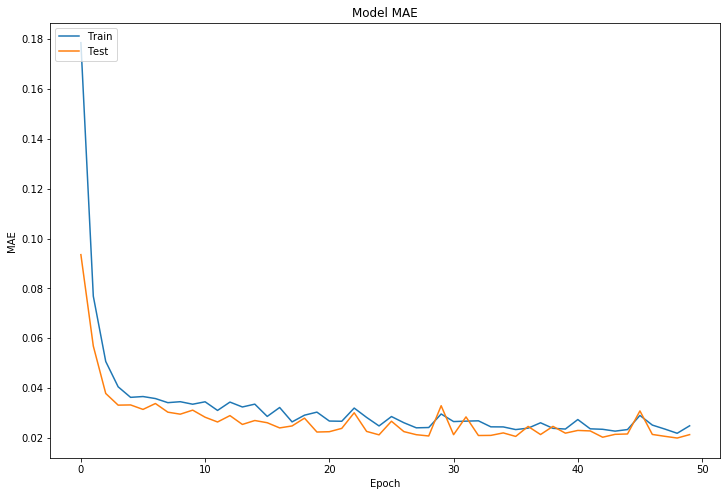

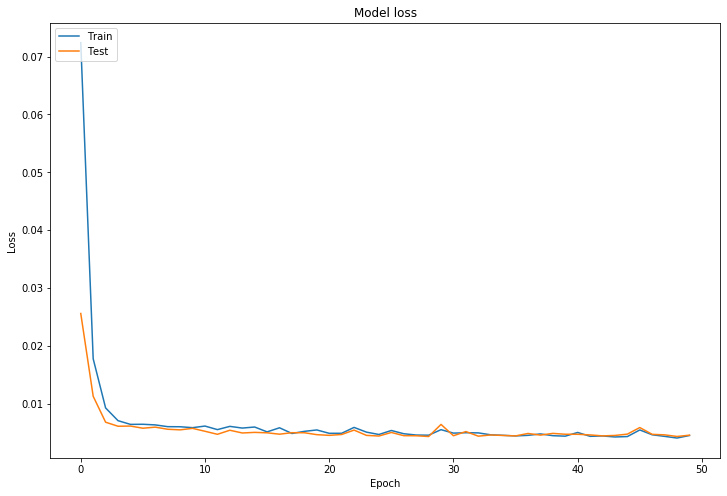

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,8))
plt.plot(history1.history['mean_absolute_error'])
plt.plot(history1.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12,8))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
def gif_some_output(d, n, f):
    def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
        from matplotlib import pyplot, animation
        from IPython.display import HTML, display, clear_output
        import random

        if filename is None:
            filename = 'animate_%06i.gif' % random.randint(0, 999999)
        # Create figure
        if figure_params is None:
            figure_params = {}
        figure = pyplot.figure(**figure_params)
        # Wrap draw_function if we need to print to console
        if verbose:
            old_draw_function = draw_function
            def draw_function(current_frame_number, total_frame_count):
                old_draw_function(current_frame_number, total_frame_count)
                print('Processed frame', current_frame_number + 1, '/', total_frame_count)
                clear_output(wait=True)
                if current_frame_number + 1 == total_frame_count:
                    print('Writing animation to file...')
                    clear_output(wait=True)
        # Generate animation
        anim = animation.FuncAnimation(
            figure, draw_function, frames=frames, interval=interval,
            init_func=lambda: None, fargs=(frames,))
        anim.save(filename, writer='imagemagick')
        # Close the animation figure so the last frame does not get displayed
        # in the notebook.
        pyplot.close()
        # Return display object for the animated GIF
        return display(HTML('<img src="' + filename + '">'))


    def animate_pose(frame, total_frames):
        pairs = [[0,1], [0,2], [1, 3], [3, 5], [2, 4], [4, 6], [1, 7], [2,8], [7, 9], [9, 11], [8, 10], [10, 12], [7, 8]]
        xs = pred_m[frame, :13]
        ys = pred_m[frame, 13:26]
        ys = 1 - ys
        plt.clf()
        plt.scatter(xs, ys)
        for pair in pairs:
            plt.plot(xs[pair], ys[pair], lw=5)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        
        
    def animate_pose_visible(frame, total_frames):
        pairs = [[0,1], [0,2], [1, 3], [3, 5], [2, 4], [4, 6], [1, 7], [2,8], [7, 9], [9, 11], [8, 10], [10, 12], [7, 8]]
        xs = pred_m[frame, :13]
        ys = pred_m[frame, 13:26]
        ys = 1 - ys
        vis = [1 if v > 0.5 else 0 for v in pred_m[frame, 26:]]
        plt.clf()
        plt.scatter(xs[vis], ys[vis])
        for pair in pairs:
            vis_or_not = [vis[point] for point in pair]
            if all(vis_or_not):
                plt.plot(xs[pair], ys[pair], lw=5)
        plt.xlim(0, 1)
        plt.ylim(0, 1)

    def generate_pred(model_, input_, n):
        pred = list(input_.copy())
        for _ in range(n):
            output = model_.predict(np.array(pred)[-nframe:].reshape(1, nframe, 13*3))[0]
            output[26:] = np.array([1 if output[i] >= 0.5 else 0 for i in range(26, 39)])
            pred.append(output)
        return np.array(pred)
    choices = np.random.choice(np.arange(d.shape[0]), n)
    
    for _ in choices:
        plot_pose_visible(d[_][0,:13], d[_, 0, 13:26], np.array(d[_, 0, 26:], dtype=int), 1, 1)
        plt.show()
        for j in f:
            pred_m = generate_pred(model, d[_], j)
            make_animation(animate_pose_visible, frames=nframe+j, interval=1, verbose=True, filename="{}-{}.gif".format(_, j))

    print(choices)

In [0]:
gif_some_output(val_input, 2, [0, 5, 15, 25])

[4493  144]


In [0]:
a = np.ones(shape=(12,3))
a[:10, 2]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [0]:
n = 0
pred_m = generate_pred(model, val_input[i], n)
make_animation(animate_pose_visible, frames=nframe+n, interval=1, verbose=True, filename="{}-{}.gif".format(i, n))

In [0]:
n = 5
pred_m = generate_pred(model, val_input[i], n)
make_animation(animate_pose_visible, frames=nframe+n, interval=1, verbose=True, filename="{}-{}.gif".format(i, n))

In [0]:
n = 45
pred_m = generate_pred(model, val_input[i], n)
make_animation(animate_pose_visible, frames=nframe+n, interval=1, verbose=True, filename="{}-{}.gif".format(i, n))